In [1]:
"""
this script converts the outputs from process_cast.m in matlab format (.mat) to .nc files
"""

# import os
# import numpy as np
# import scipy.io as sio
# import xarray as xr
#
#
# # ---------------------------------------------------------
# # Helper: convert MATLAB structs recursively into dicts
# # ---------------------------------------------------------
# def matlab_struct_to_dict(matobj):
#     out = {}
#     for field in matobj._fieldnames:
#         val = getattr(matobj, field)
#
#         # Nested struct
#         if hasattr(val, "_fieldnames"):
#             out[field] = matlab_struct_to_dict(val)
#
#         # MATLAB cell arrays → Python lists
#         elif isinstance(val, np.ndarray) and val.dtype == object:
#             out[field] = [matlab_struct_to_dict(v) if hasattr(v, "_fieldnames") else v
#                           for v in val]
#
#         else:
#             out[field] = val
#
#     return out
#
#
# # ---------------------------------------------------------
# # Helper: flatten nested dicts into xarray-friendly form
# # ---------------------------------------------------------
# def flatten_dict(prefix, d, out):
#     for key, val in d.items():
#         name = f"{prefix}_{key}" if prefix else key
#
#         if isinstance(val, dict):
#             flatten_dict(name, val, out)
#
#         else:
#             out[name] = val
#
#     return out
#
#
# # ---------------------------------------------------------
# # User settings
# # ---------------------------------------------------------
# file_dir = "/Users/iw2g24/PycharmProjects/COOKIES/ladcp_data/"
# out_dir  = "/Users/iw2g24/PycharmProjects/COOKIES/ladcp_nc/"
# stations = ["001", "002", "003", "004", "005"]
#
# os.makedirs(out_dir, exist_ok=True)
#
#
# # ---------------------------------------------------------
# # Process each station
# # ---------------------------------------------------------
# for stn in stations:
#
#     mat_path = os.path.join(file_dir, f"{stn}.mat")
#     if not os.path.exists(mat_path):
#         print(f"Missing: {mat_path}")
#         continue
#
#     print(f"Processing {mat_path}")
#
#     # Load MAT file
#     mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
#
#     # Extract MATLAB structs
#     structs = {}
#     for key, val in mat.items():
#         if hasattr(val, "_fieldnames"):
#             structs[key] = matlab_struct_to_dict(val)
#
#     # Flatten all structs into a single dictionary
#     flat = {}
#     for name, struct in structs.items():
#         flat = flatten_dict(name, struct, flat)
#
#     # Build xarray Dataset
#     ds = xr.Dataset()
#
#     for key, val in flat.items():
#
#         # Scalars → attributes
#         if np.isscalar(val) or isinstance(val, (str, bytes)):
#             ds.attrs[key] = val
#
#         # 1D or 2D numeric arrays → variables
#         elif isinstance(val, np.ndarray) and np.issubdtype(val.dtype, np.number):
#             if val.ndim == 1:
#                 ds[key] = ("dim_" + key, val)
#             elif val.ndim == 2:
#                 ds[key] = (("dim0_" + key, "dim1_" + key), val)
#
#         # Everything else → store as string attribute
#         else:
#             ds.attrs[key] = str(val)
#
#     # Save NetCDF
#     out_path = os.path.join(out_dir, f"ladcp_{stn}.nc")
#     ds.to_netcdf(out_path)
#
#     print(f"Saved NetCDF → {out_path}")


'\nthis script converts the outputs from process_cast.m in matlab format (.mat) to .nc files\n'

In [17]:
import xarray as xr

stations = ['002', '003', '004', '005']

ladcp_002 = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/ladcp_nc/ladcp_002.nc')
print(ladcp_002.dim_dr_u)

<xarray.DataArray 'dim_dr_u' (dim_dr_u: 426)> Size: 3kB
[426 values with dtype=int64]
Dimensions without coordinates: dim_dr_u


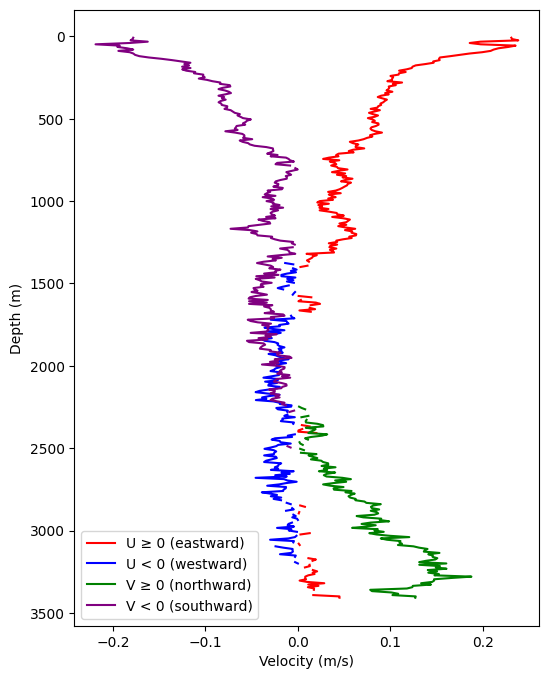

In [21]:
# import matplotlib.pyplot as plt
#
# u = ladcp_002["dr_u"].values
# v = ladcp_002["dr_v"].values
# z = ladcp_002["dr_z"].values
#
# plt.figure(figsize=(6,8))
# plt.plot(u, z, label="U (East-West)")
# plt.plot(v, z, label="V (South-North)")
#
# plt.gca().invert_yaxis()
# plt.xlabel("Velocity (m/s)")
# plt.ylabel("Depth (m)")
# plt.legend()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

u = ladcp_002["dr_u"].values
v = ladcp_002["dr_v"].values
z = ladcp_002["dr_z"].values

plt.figure(figsize=(6,8))

# --- U component ---
plt.plot(np.where(u >= 0, u, np.nan), z, color="red", label="U ≥ 0 (eastward)")
plt.plot(np.where(u < 0,  u, np.nan), z, color="blue", label="U < 0 (westward)")

# --- V component ---
plt.plot(np.where(v >= 0, v, np.nan), z, color="green", label="V ≥ 0 (northward)")
plt.plot(np.where(v < 0,  v, np.nan), z, color="purple", label="V < 0 (southward)")

plt.gca().invert_yaxis()
plt.xlabel("Velocity (m/s)")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()



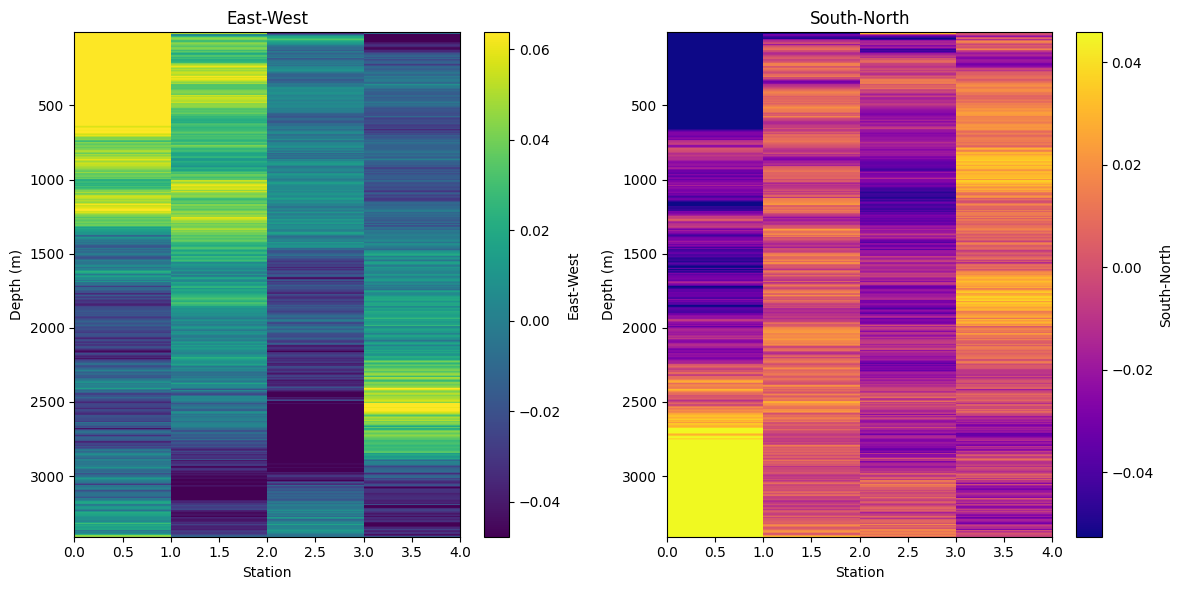

In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

us = []
vs = []
depths = []

file_dir = ''

stations = ['002','003', '004', '005']

for stn in stations:
    ds = xr.open_dataset(f'/Users/iw2g24/PycharmProjects/COOKIES/ladcp_nc/ladcp_{stn}.nc')
    u = ds.dr_u.values
    v = ds.dr_v.values
    z = ds.dr_z.values

    # order = np.argsort(z)
    # u = u[order]
    # v = v[order]
    # z = z[order]

    us.append(u)
    vs.append(v)
    depths.append(z)

z_min = max(z.min() for z in depths)   # shallowest common depth
z_max = min(z.max() for z in depths)   # deepest common depth

# Ensure increasing depth
if z_min > z_max:
    z_min, z_max = z_max, z_min

z_grid = np.linspace(z_min, z_max, 1200)

u_grid = np.vstack([np.interp(z_grid, depths[i], us[i])
                    for i in range(len(stations))])

v_grid = np.vstack([np.interp(z_grid, depths[i], vs[i])
                    for i in range(len(stations))])

# x: station index
x = np.arange(len(stations))
x_edges = np.arange(len(stations) + 1)

# y: depth edges
z_edges = np.zeros(len(z_grid) + 1)
z_edges[1:-1] = (z_grid[:-1] + z_grid[1:]) / 2
z_edges[0] = z_grid[0] - (z_grid[1] - z_grid[0]) / 2
z_edges[-1] = z_grid[-1] + (z_grid[-1] - z_grid[-2]) / 2

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

variables = [
    (u_grid, "East-West", "viridis",
     np.percentile(u_grid, 5),
     np.percentile(u_grid, 95)),

    (v_grid, "South-North", "plasma",
     np.percentile(v_grid, 5),
     np.percentile(v_grid, 95))]


for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x_edges,
        z_edges,
        var2d.T,
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )
    #
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_ylabel("Depth (m)")


    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)


plt.tight_layout()
plt.show()

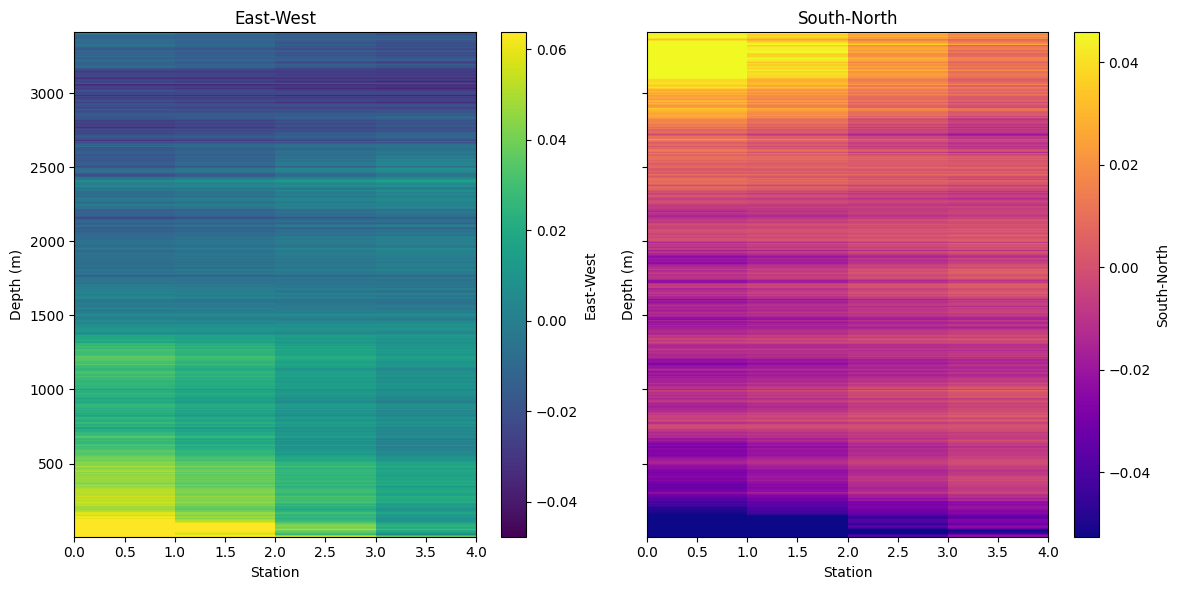

In [20]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Build smoothed transect grids - using the grids from above
# -----------------------------

sigma = 2.0

u_grid_smooth  = gaussian_filter1d(u_grid,  sigma=sigma, axis=0)
v_grid_smooth = gaussian_filter1d(v_grid, sigma=sigma, axis=0)


# -----------------------------
# 2. Plot smoothed transects
# -----------------------------

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

variables = [
    (u_grid_smooth,  "East-West",        "viridis",
     np.percentile(u_grid, 5),  np.percentile(u_grid, 95)),

    (v_grid_smooth, "South-North",    "plasma",
     np.percentile(v_grid, 5), np.percentile(v_grid, 95))
]

for ax, (var2d, title, cmap, vmin, vmax) in zip(axs, variables):

    pcm = ax.pcolormesh(
        x_edges,
        z_edges,
        var2d.T,
        shading='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )
    #
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Station")
    ax.set_ylabel("Depth (m)")


    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(title)


plt.tight_layout()
plt.show()
